# 线性回归从零开始实现

* 从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

**1. 生成数据集**

In [ ]:
!pip install d2l

In [ ]:
!pip install matplotlib==3.0

In [ ]:
import random
import torch 
from d2l import torch as d2l

* 我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

* 其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。可以将 𝜖 视为模型预测和标签时的潜在观测误差。下面的代码生成合成数据集。

In [ ]:
def synthetic_data(w, b, num_examples):
  # 生成 y = wX + b + 噪声
  X = torch.normal(0, 1, (num_examples, len(w)))  # 生成的 X，表示均值为0，方差为1的随机数，其大小（行列）为 (num_examples, len(w))
  y = torch.matmul(X, w) + b  # matmul 可以进行张量乘法, 输入可以是高维, mm 表示矩阵乘法
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1,1))  # 将 X，y作为列向量返回

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

* 注意，**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**。


In [ ]:
print('features:',features[0:4],'\n','labels:',labels[0:4])

features: tensor([[-0.4697, -0.5577],
        [ 0.1436, -1.6295],
        [ 1.3075,  0.8565],
        [ 0.6415,  1.1618]]) 
 labels: tensor([[ 5.1472],
        [10.0184],
        [ 3.9163],
        [ 1.5345]])


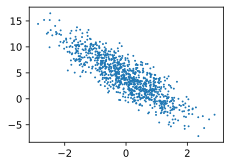

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)  # 1 表示的是点的直径大小 
# detach()分离出数值，不含梯度

**2. 读取数据集**

* **定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**。
每个小批量包含一组特征和标签。

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)     # features 是1000x2 的矩阵， len(features) = 1000
    indices = list(range(num_examples)) # 0-999的列表
    random.shuffle(indices)  # random.shuffle() 表示将列表顺序打乱，即这些样本是随机读取的，没有特定的顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # yield 是一个 generator 函数，不断的返回一个x和一个y值。

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2927,  0.3971],
        [ 1.0696, -1.6469],
        [-2.4960,  0.4137],
        [ 1.4055, -1.4355],
        [ 1.2130, -0.7828],
        [ 1.6690,  0.8338],
        [-0.0734, -2.4048],
        [-0.8577, -1.5032],
        [-0.8626,  0.1815],
        [ 0.4254,  0.1007]]) 
 tensor([[ 3.4424],
        [11.9522],
        [-2.2039],
        [11.8950],
        [ 9.2933],
        [ 4.6998],
        [12.2241],
        [ 7.5788],
        [ 1.8780],
        [ 4.7159]])


**3. 定义初始化参数**

In [ ]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

**4. 定义模型**

In [ ]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

**5. 定义损失函数**

In [ ]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

**6. 定义优化算法**

In [ ]:
def sgd(params, lr, batch_size):   # params 表示w和b
    """小批量随机梯度下降"""
    with torch.no_grad():     # 一个上下文管理器，被该语句 wrap 起来的部分将不会track梯度
        for param in params:
            param -= lr * param.grad / batch_size  # 因为求的梯度大小是一个批量样本的总和
            param.grad.zero_()

**7. 训练过程**

In [ ]:
lr = 0.03
num_epochs = 3  # 表示整个模型扫3遍
net = linreg
loss = squared_loss

In [ ]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():   # 在整个数据上的评价损失函数
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036662
epoch 2, loss 0.000131
epoch 3, loss 0.000052


* 比较真实参数和通过训练学到的参数来评估训练的成功程度

In [ ]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0011], grad_fn=<SubBackward0>)
b的估计误差: tensor([-7.9632e-05], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

* 通过使用深度学习框架来简洁实现线性回归模型

**1. 生成数据集**

In [ ]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

**2. 读取数据**

* 调用框架中现有的API来读取数据。
* TensorDataset( ) 可以用来对 tensor 进行打包，就好像 python 中的 zip 功能。该类通过每一个 tensor 的第一个维度进行索引。因此，该类中的 tensor 第一维度必须相等。
* DataLoader( )就是用来包装所使用的数据，每次抛出一批数据。

In [ ]:
def load_array(data_arrays, batch_size, is_train=True): 
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # * 表示对list解开入参
    return data.DataLoader(dataset, batch_size, shuffle=is_train)  # is_train 表示希望数据迭代器对象在每个迭代周期内打乱数据

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.6613, -0.2064],
         [ 0.0137,  0.6189],
         [-0.4853,  0.7406],
         [ 1.1490,  1.0176],
         [ 1.6495, -0.5737],
         [-1.1819, -0.5928],
         [ 0.2440, -0.0463],
         [ 1.4493,  0.7751],
         [ 0.9177, -0.7825],
         [-1.3396, -1.1959]]), tensor([[8.2167],
         [2.1278],
         [0.7136],
         [3.0329],
         [9.4517],
         [3.8528],
         [4.8604],
         [4.4602],
         [8.6971],
         [5.5738]])]

**3. 使用框架的预定义好的层**

* Sequential类将多个层串联在一起，类似于一个容器。 当给定输入数据时，Sequential实例将数据传入到第一层， 然后将第一层的输出作为第二层的输入，以此类推。 在下面的例子中，模型只包含一个层，因此实际上不需要Sequential。 但是由于以后几乎所有的模型都是多层的，在这里使用Sequential可以熟悉一下“标准的流水线”。

In [ ]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1)) # 指定 输入和输出 的维度

**4. 初始化模型参数**

In [ ]:
net[0].weight.data.normal_(0, 0.01)  # [0]表示的是容器里面的第一层，normal_ 表示使用正态分布来替换data的值

tensor([[ 0.0043, -0.0016]])

In [ ]:
net[0].bias.data.fill_(0)  

tensor([0.])

**5. 损失函数**

* **计算均方误差使用的是`MSELoss`类，也称为平方$L_2$范数**。
默认情况下，它返回所有样本损失的平均值。

In [ ]:
loss = nn.MSELoss()

**6. 实例化SDG实例**

In [ ]:
trainer = torch.optim.SGD(net.parameters(),lr = 0.03)

**7. 训练过程**

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()  # 调用step()来进行模型的更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000197
epoch 2, loss 0.000099
epoch 3, loss 0.000098


In [ ]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0009, -0.0005])
b的估计误差： tensor([-0.0004])
